In [11]:
import numpy as np
from scipy.linalg import svd

In [12]:
# Set random seed for reproducibility (optional)
np.random.seed(0)

# Sample 500 points from a 3D Gaussian (as in the MATLAB code)
n = 500
d = 2
lambda_ = 1
u = np.random.normal(0, 1, (n, d))
# fix variable naming consistency
u[:, 0] = lambda_ * u[:, 0]
u_norm = np.linalg.norm(u, axis=1, keepdims=True)
r = np.sqrt(np.random.rand(n, 1)) * 1/100 + 99/100
u_trans = u / u_norm

# X_tar = r * u_trans (element-wise multiplication)
X_tar = r * u_trans
# n = X_tar.shape[0] (already n=500, but keep for consistency)
n = X_tar.shape[0]

# Form the anisotropic graph Laplacian inputs
sq_tar = np.sum(X_tar ** 2, axis=1)
H = sq_tar[:, None] + sq_tar[None, :] - 2 * (X_tar @ X_tar.T)
epsilon = 0.5 * np.median(H) / np.log(n + 1)
# Kernel function
def ker(X):
    sq_tar = np.sum(X ** 2, axis=1)
    return np.exp(-(sq_tar[:, None] + sq_tar[None, :] - 2 * (X @ X.T)) / (2 * epsilon))

data_kernel = ker(X_tar)
# Degree-like quantities needed by grad_ker1 / K_tar_eval
p_x = np.sqrt(np.sum(data_kernel, axis=1))
p_y = p_x.copy()

# Diffusion maps normalization and symmetric random-walk operator
data_kernel_norm = data_kernel / (p_x[:, None] + 1e-12) / (p_y[None, :] + 1e-12)
D_y = np.sum(data_kernel_norm, axis=0)
rw_kernel = 0.5 * (data_kernel_norm / (D_y + 1e-12) + (data_kernel_norm / (D_y + 1e-12)).T)

# SVD of rw_kernel and DM spectral auxiliaries
phi_dm, s_dm, _ = svd(rw_kernel)
lambda_ns = s_dm
lambda_ = 1.0 - lambda_ns
inv_lambda = np.zeros_like(lambda_)
if inv_lambda.shape[0] > 1:
    inv_lambda[1:] = 1.0 / (lambda_[1:] + 1e-18)
inv_lambda = inv_lambda * epsilon

# Regularization and tolerance for DM spectrum
tol = 1e-6
lambda_ns_mod = np.copy(lambda_ns)
lambda_ns_mod[lambda_ns_mod < tol] = 0
below_tol = int(np.sum(lambda_ns < tol))
above_tol_dm = int(n - below_tol)
reg = 1e-3
lambda_ns_inv = np.zeros_like(lambda_ns)
mask = lambda_ns >= tol
lambda_ns_inv[mask] = epsilon / (lambda_ns[mask] + reg)

In [13]:
# EDMD with Brownian time pairs matched to kernel epsilon (thin shell)

# === Time-pair generation on a thin shell (EDMD) ===
# Mapping between kernel bandwidth and heat-kernel time: for exp(-||x-y||^2/(2*epsilon)),
# the corresponding heat time is t = epsilon / (2D). Here we take D = 1 => Delta_t = epsilon/2,
# and choose sigma ~ sqrt(epsilon) to generate a small Brownian step.
D_edmd = 1.0
Delta_t = epsilon / (2.0 * D_edmd)
sigma = np.sqrt(epsilon)
# Optional: small dimensionality correction so the tangent noise variance matches ambient (can be commented out)
if d > 1:
    sigma = sigma * np.sqrt(d / (d - 1))

rng = np.random.default_rng()
Xi = rng.normal(0.0, 1.0, size=X_tar.shape)
# Project noise to the tangent plane at each X_tar so the perturbation stays on the thin shell
proj = np.sum(Xi * X_tar, axis=1, keepdims=True)
Xi_tan = Xi - proj * X_tar
Y_pairs = X_tar + sigma * Xi_tan
# Renormalize back to the original radius (thin shell)
radius = np.linalg.norm(X_tar, axis=1, keepdims=True) + 1e-12
Y_pairs = Y_pairs / (np.linalg.norm(Y_pairs, axis=1, keepdims=True) + 1e-12) * radius

In [14]:
# === Dictionary definition and evaluations (anchors = X_tar) ===
# Source side: use nearest anchor to map each X_tar[k] to an index (approximates one-hot dictionary evaluation Psi(X)).
# Target side: use Gaussian responsibilities W(k,j) to softly assign Y_pairs[k] to anchors (soft dictionary evaluation Psi(Y)).
try:
    from sklearn.neighbors import NearestNeighbors
    nn = NearestNeighbors(n_neighbors=1).fit(X_tar)
    src_idx = nn.kneighbors(X_tar, return_distance=False).ravel()
except Exception:
    # Fallback: identity mapping
    src_idx = np.arange(n)

sqA = np.sum(X_tar**2, axis=1)                 # (n,)
sqY = np.sum(Y_pairs**2, axis=1)               # (n,)
# Responsibilities from Y to anchors (row-normalized to get a soft assignment)
W = np.exp(-(sqY[:, None] + sqA[None, :] - 2.0 * (Y_pairs @ X_tar.T)) / (2.0 * epsilon))
W = W / (np.sum(W, axis=1, keepdims=True) + 1e-12)

# === Build sample-space transition K_data, symmetrize, and eigendecompose ===
# Accumulate transitions for each source anchor i from the responsibilities of corresponding samples k, then row-normalize
# to obtain a Markov matrix in the anchor (dictionary) basis.
K_count = np.zeros((n, n))
for k in range(n):
    i = src_idx[k]
    K_count[i, :] += W[k, :]

In [15]:
# Row-normalize to get a Markov matrix
row_sums = np.sum(K_count, axis=1, keepdims=True) + 1e-12
K_data = K_count / row_sums
# Symmetrize to align with the symmetric spectral pipeline, then perform eigen-decomposition (sorted descending)
K_sym = 0.5 * (K_data + K_data.T)
# Numerical clipping to [0,1] to avoid tiny negatives causing eig issues
K_sym = np.clip(K_sym, 0.0, 1.0)

In [16]:
# Eigen-decomposition (symmetric)
s_edmd, phi_edmd = np.linalg.eigh(K_sym)  # s_edmd ascending
# Sort descending to match prior convention (largest first)
order = np.argsort(-s_edmd)
s_edmd = s_edmd[order]
phi_edmd = phi_edmd[:, order]

# === Continuous-time generator spectrum (Koopman generator) and Green-like weights ===
# Continuous-time eigenvalues: mu = log(s) / Delta_t. Then build inverse (with sign-regularization and capping)
# as Green-like weights for the iteration.
s_safe = np.clip(s_edmd, 1e-12, 1.0)
mu_edmd = np.log(s_safe) / Delta_t

# Define EDMD-based inverse spectral weights (Green-like), skipping near-zero modes
reg_mu = 1e-3
above_tol_mask = np.abs(mu_edmd) > 1e-10
above_tol_edmd = int(np.sum(above_tol_mask))
inv_mu = np.zeros_like(mu_edmd)
inv_mu[above_tol_mask] = 1.0 / (mu_edmd[above_tol_mask] + reg_mu * np.sign(mu_edmd[above_tol_mask]))

# EDMD spectral weights (Green-like) for optional use in iteration
cap = 1e3
lambda_ns_s_ns_edmd = np.minimum(np.abs(inv_mu[:above_tol_edmd]), cap)

In [17]:
# Import the translated kernel and gradient functions
from grad_ker1 import grad_ker1
from K_tar_eval import K_tar_eval

In [18]:
# Iterative scheme parameters
iter = 1000
h = 5
m = 700

# Initialize particles
u = np.random.normal(0, 1, (m, d))
u_norm = np.linalg.norm(u, axis=1, keepdims=True)
r = np.sqrt(np.random.rand(m, 1)) * 1/100 + 99/100
u_trans = u / u_norm
x_init = r * u_trans
x_init = x_init[x_init[:, 1] > 0.7, :]
m = x_init.shape[0]
x_t = np.zeros((m, d, iter))
x_t[:, :, 0] = x_init

# Precompute quantities
p_tar = np.sum(data_kernel, axis=0)
D = np.sum(data_kernel / np.sqrt(p_tar) / (np.sqrt(p_tar)[:, None] + 1e-12), axis=1)

# Mixed spectral setup: build DM weights once
# inv_K_ns_s_ns = phi_dm @ np.diag(lambda_ns_inv * inv_lambda * lambda_ns_inv) @ phi_dm.T
# (We keep only the vectors used downstream; remove unused full-operator reconstruction)
lambda_s_s_ns = inv_lambda * inv_lambda * lambda_ns_inv
lambda_s_s_ns = lambda_s_s_ns[:above_tol_dm]
lambda_ns_s_ns_dm = lambda_ns_inv * inv_lambda * lambda_ns_inv
lambda_ns_s_ns_dm = lambda_ns_s_ns_dm[:above_tol_dm]

# Toggle: choose basis and weights
USE_EDMD_BASIS = True   # True: use EDMD eigenvectors; False: use DM eigenvectors
USE_EDMD_WEIGHTS = True # True: use EDMD Green-like weights; False: use DM weights

phi_proj = phi_edmd if (USE_EDMD_BASIS and 'phi_edmd' in globals()) else phi_dm
if USE_EDMD_WEIGHTS and 'lambda_ns_s_ns_edmd' in globals():
    lambda_ns_s_ns = lambda_ns_s_ns_edmd
    above_tol = above_tol_edmd
else:
    lambda_ns_s_ns = lambda_ns_s_ns_dm
    above_tol = above_tol_dm  # projector uses first above_tol modes consistent with chosen weights

sum_x = np.zeros((m, d))
for t in range(iter - 1):
    grad_matrix = grad_ker1(x_t[:, :, t], X_tar, p_tar, sq_tar, D, epsilon)
    cross_matrix = K_tar_eval(X_tar, x_t[:, :, t], p_tar, sq_tar, D, epsilon)
    for i in range(d):
        sum_x[:, i] = np.sum(grad_matrix[:, :, i] @ phi_proj[:, :above_tol] @ np.diag(lambda_ns_s_ns) @ phi_proj[:, :above_tol].T @ cross_matrix, axis=1)
    x_t[:, :, t + 1] = x_t[:, :, t] - h / m * sum_x

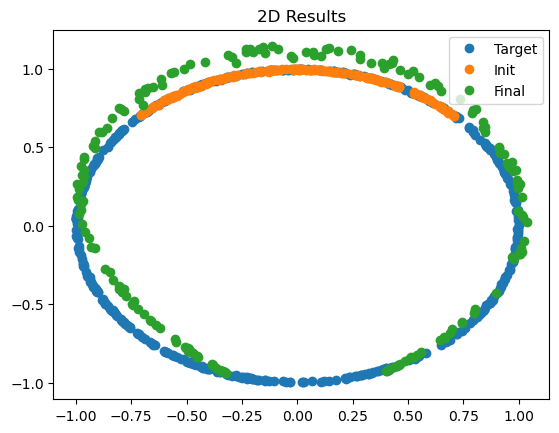

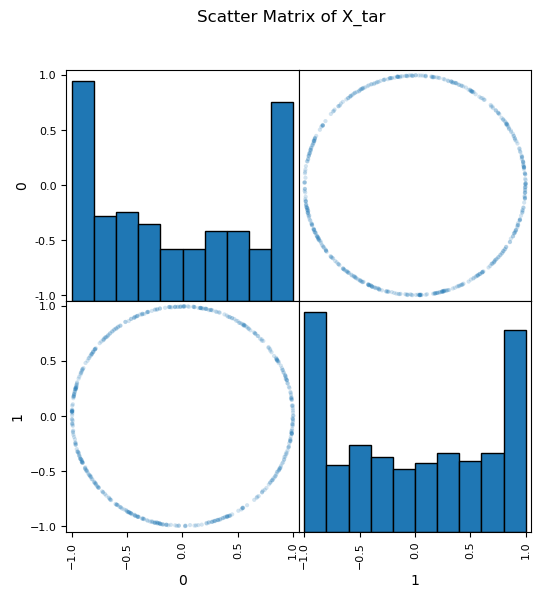

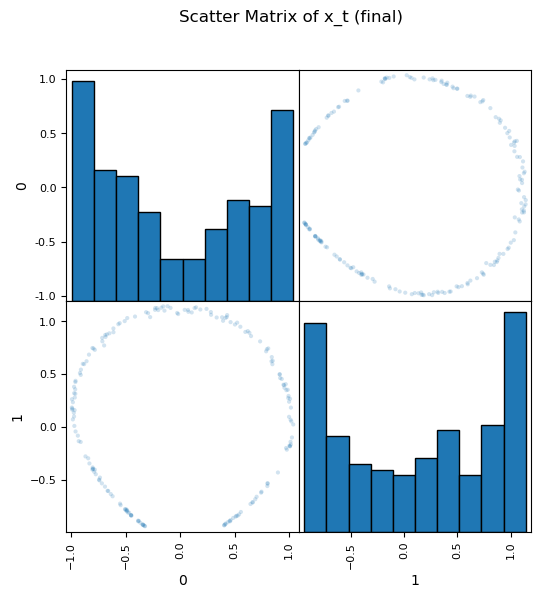

In [19]:
# Translation of script_nd_sphere.m lines 144-168 to Python
import pandas as pd
import matplotlib.pyplot as plt

# Plotting results
if d == 2:
    plt.figure()
    plt.plot(X_tar[:, 0], X_tar[:, 1], 'o', label='Target')
    plt.plot(x_t[:, 0, 0], x_t[:, 1, 0], 'o', label='Init')
    plt.plot(x_t[:, 0, -1], x_t[:, 1, -1], 'o', label='Final')
    plt.legend()
    plt.title('2D Results')
    plt.show()
else:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_tar[:, 0], X_tar[:, 1], X_tar[:, 2], label='Target')
    ax.scatter(x_t[:, 0, 0], x_t[:, 1, 0], x_t[:, 2, 0], label='Init')
    ax.scatter(x_t[:, 0, -1], x_t[:, 1, -1], x_t[:, 2, -1], label='Final')
    ax.legend()
    plt.title('3D Results')
    plt.show()
    # Additional plot for final state only
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111, projection='3d')
    ax2.scatter(x_t[:, 0, 0], x_t[:, 1, 0], x_t[:, 2, 0], label='Init')
    ax2.scatter(x_t[:, 0, -1], x_t[:, 1, -1], x_t[:, 2, -1], label='Final')
    ax2.legend()
    plt.title('3D Final State')
    plt.show()

pd.plotting.scatter_matrix(
    pd.DataFrame(X_tar),
    alpha=0.2,
    figsize=(6, 6),
    diagonal='hist',
    hist_kwds={'edgecolor': 'black'}
)
plt.suptitle('Scatter Matrix of X_tar')
plt.show()

pd.plotting.scatter_matrix(
    pd.DataFrame(x_t[:, :, -1]),
    alpha=0.2,
    figsize=(6, 6),
    diagonal='hist',
    hist_kwds={'edgecolor': 'black'}
)
plt.suptitle('Scatter Matrix of x_t (final)')
plt.show()

In [20]:
# Quick check: print epsilon and Delta_t used in EDMD
print('EDMD epsilon =', float(epsilon))
print('EDMD Delta_t =', float(Delta_t))
print('epsilon / (2*Delta_t) =', float(epsilon/(2.0*Delta_t)))

EDMD epsilon = 0.15871308194053385
EDMD Delta_t = 0.07935654097026693
epsilon / (2*Delta_t) = 1.0
